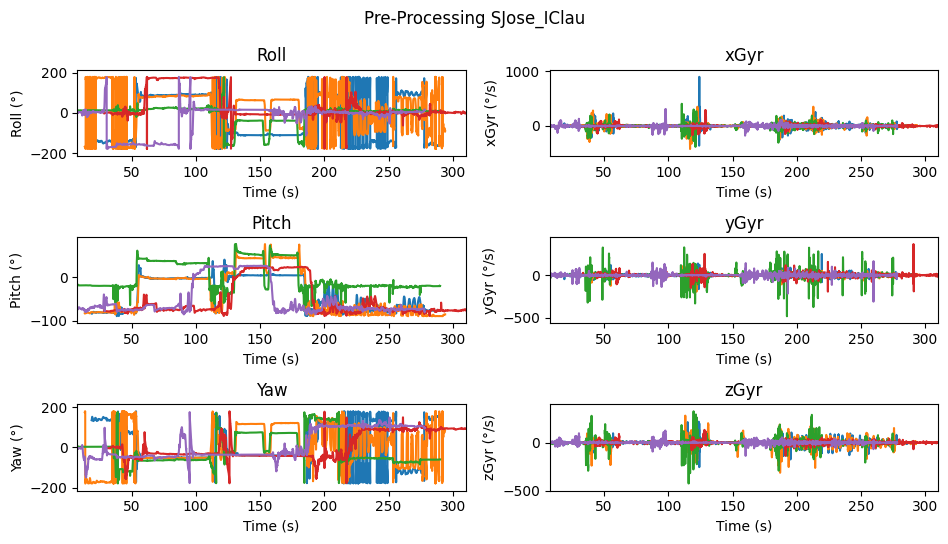

c:\Users\Jose Amorocho\OneDrive\Documentos\SAM_Pyhton\Processing.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['TimeStamp'] = time
c:\Users\Jose Amorocho\OneDrive\Documentos\SAM_Pyhton\Processing.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var.iloc[drv[f]:drv[(f)+1]] = - \


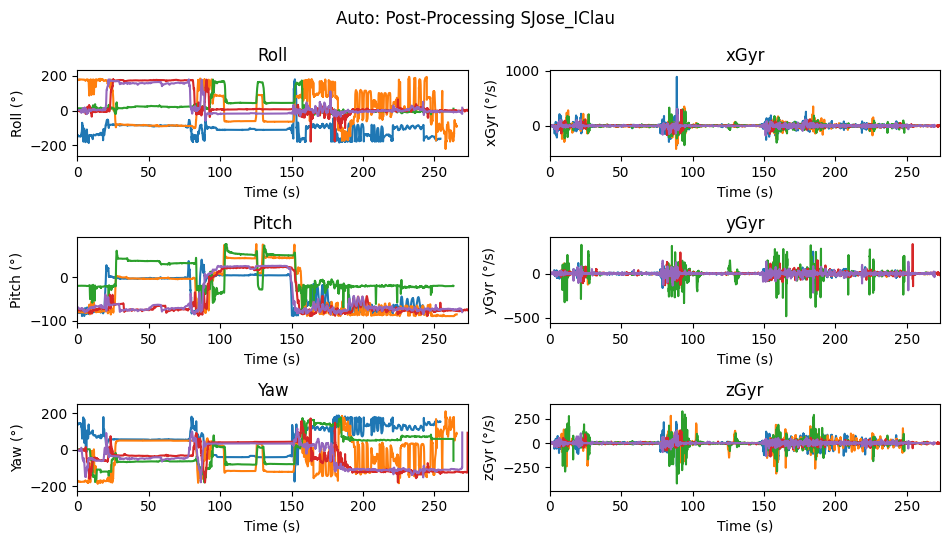

In [45]:
from Angles_Determination import Angles_Ankle, Angles_Hip, Angles_Knee
from Load_Files import Load_Files
from Processing import Change_Range, Plot_Data, Resample, Same_size, Set_Data, Syncronize
test= 'SJose_IClau' 
dia = 'Dia_2'
dir= "./2022_10_18/"+dia+'/'+test+'/'
# Load the data
data= Load_Files(dir)
# Plot the data
Plot_Data(data,test,'Pre-Processing')
# Set Start to 0 Sensors(SAM).
data= Set_Data(data)
# Adjust angles range to a continous angles.
data= Change_Range(data,150)
# Oversample the data to 200 Hz.
data= Resample(data,200)
# Synchronize the data.
data= Syncronize(data)
# Resample the data to 50 Hz.
data= Resample(data,50)

Plot_Data(data,test,'Auto: Post-Processing')

In [46]:
# Make all the dataframes have the same size.
data= Same_size(data)
#Finds Angles
time= data['SENSOR06']['TimeStamp']
ang_ankle= Angles_Ankle(data['SENSOR06'],data['SENSOR08'],'l')
ang_knee= Angles_Knee(data['SENSOR07'],data['SENSOR06'],'l')
ang_hip= Angles_Hip(data['SENSOR11'],data['SENSOR07'],'l')

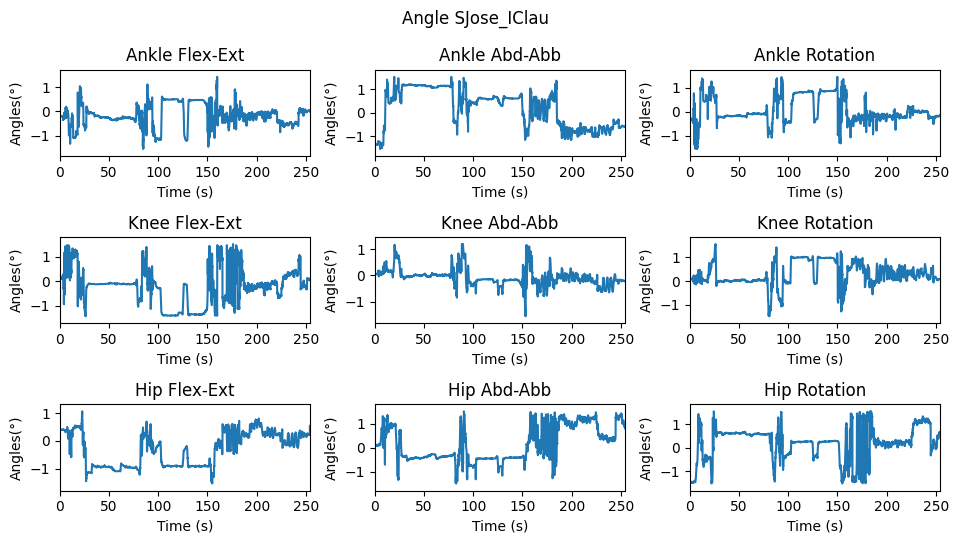

In [47]:
from matplotlib.pyplot import show, subplots

fig, ((fe1,aa1,ro1),(fe2,aa2,ro2),(fe3,aa3,ro3)) = subplots(3, 3, figsize=(9.6, 5.5))
fe1.plot(data['SENSOR06']['TimeStamp'], ang_ankle['Fle_Ext'])
aa1.plot(data['SENSOR06']['TimeStamp'], ang_ankle['Abd_Abb'])
ro1.plot(data['SENSOR06']['TimeStamp'], ang_ankle['Rot'])

fe2.plot(data['SENSOR06']['TimeStamp'], ang_knee['Fle_Ext'])
aa2.plot(data['SENSOR06']['TimeStamp'], ang_knee['Abd_Abb'])
ro2.plot(data['SENSOR06']['TimeStamp'], ang_knee['Rot'])

fe3.plot(data['SENSOR06']['TimeStamp'], ang_hip['Fle_Ext'])
aa3.plot(data['SENSOR06']['TimeStamp'], ang_hip['Abd_Abb'])
ro3.plot(data['SENSOR06']['TimeStamp'], ang_hip['Rot'])

fig.suptitle('Angle '+test)
fe1.set_xlabel('Time (s)')
fe1.set_ylabel('Angles(°)')
fe1.set_title('Ankle Flex-Ext')
aa1.set_xlabel('Time (s)')
aa1.set_ylabel('Angles(°)')
aa1.set_title('Ankle Abd-Abb')
ro1.set_xlabel('Time (s)')
ro1.set_ylabel('Angles(°)')
ro1.set_title('Ankle Rotation')
fe1.margins(0, 0.1)
aa1.margins(0, 0.1)
ro1.margins(0, 0.1)

fe2.set_xlabel('Time (s)')
fe2.set_ylabel('Angles(°)')
fe2.set_title('Knee Flex-Ext')
aa2.set_xlabel('Time (s)')
aa2.set_ylabel('Angles(°)')
aa2.set_title('Knee Abd-Abb')
ro2.set_xlabel('Time (s)')
ro2.set_ylabel('Angles(°)')
ro2.set_title('Knee Rotation')
fe2.margins(0, 0.1)
aa2.margins(0, 0.1)
ro2.margins(0, 0.1)

fe3.set_xlabel('Time (s)')
fe3.set_ylabel('Angles(°)')
fe3.set_title('Hip Flex-Ext')
aa3.set_xlabel('Time (s)')
aa3.set_ylabel('Angles(°)')
aa3.set_title('Hip Abd-Abb')
ro3.set_xlabel('Time (s)')
ro3.set_ylabel('Angles(°)')
ro3.set_title('Hip Rotation')
fe3.margins(0, 0.1)
aa3.margins(0, 0.1)
ro3.margins(0, 0.1)

fig.tight_layout()
show()